# ~~Nightlights for Damage Assessment~~ Nightlights Processing Utilities
> ~~Using nightlights satellite imagery for typhoon damage assessment~~ Utilities for Processing Nightlights Data

## Install

`pip install git+https://github.com/butchland/ntlights-processing-utils.git`

## How to use

* ~~Download the nightlights satellite imagery for the period before and after the disaster~~
* ~~Download the geospatial admin boundaries for the areas concerned~~
* ~~Download and scrape the damage assessment situationers as ground truth~~
* ~~Preprocess the situationrers to extract the locations and damage assessment~~
* ~~Wrangle and link the damage assessment locations to the admin boundaries~~
* ~~Extract the radiance data from the nightlights satellite~~
* ~~Analyze the patterns for radiance data for highly damaged areas vs undamaged or low damage areas~~
* ~~Write up conclusions~~

### Query what images are relevant for what dates and what areas
* Fetch monthly catalogs of VIIRS NDB night lights imagery (2012-2020) 
* Create a searchable database of images for each day of all the night lights images
* Create an API to search and filter images by date and area boundary (as well as cache! the metadata)
* Create an API to evaluate overlap of images to area boundary
* Create an API to download selected images
  

Lets start with an GeoDataFrame that is the bounding box of the AOI (Philippines)

In [ ]:
#| hide

import requests
import json
from fastcore.all import L
import pandas as pd
from typing import Any
from urllib.parse import urlparse
from pathlib import Path
import numpy as np
import re
from shapely.geometry import Polygon, box
from shapely import wkt
import geopandas as gpd
import sqlite3 as sql3
from pandas.io import sql 
import sqlalchemy as sqalc
import geowrangler.area_zonal_stats as azs

In [ ]:
#| hide
import matplotlib.pyplot as plt

In [ ]:
#| hide
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',120)

In [ ]:
#| exporti
from ntlights_processing_utils.fetch_coords import search_dates_aoi 
from ntlights_processing_utils.eval_overlap import compute_overlaps
from ntlights_processing_utils.download_rasters import download_items

In [ ]:
aoi = gpd.read_file('../data/admin_areas/ph_admin_bbox_wgs84.geojson')

Lets search for images overlapping the AOI for a particular date, in this case `20180501` or May 1, 2018

In [ ]:
%%time
matched = search_dates_aoi(aoi, date_param='20180501')

CPU times: user 79.7 ms, sys: 60.1 ms, total: 140 ms
Wall time: 137 ms


Notice how fast the retrieval is -- that's because the particular date has already been cached.

> _For dates that haven't been cached, the time can take between 10-15 minutes, depending on the internet speed_.

In [ ]:
len(matched)

5

There are 5 images for the date that overlaps the AOI, but which ones are the most relevant?

In [ ]:
matched

,href,item_href,stem,suffix,base_url,folder,product_id,start_date,first_scantime,end_scantime,orbital_nbr,create_datetime,data_origin,data_domain,vflag_file,vflag_href,cache_stem,asset_href,geometry
80,./SVDNB_npp_d20180501_t1634142_e1639546_b33728_c20180501223954897862_noac_ops.rade9.co.json,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1634142_e1639546_b33728_c20180501223954897...,SVDNB_npp_d20180501_t1634142_e1639546_b33728_c20180501223954897862_noac_ops,rade9.co.json,https://globalnightlight.s3.amazonaws.com,npp_201805,SVDNB_npp,20180501,1634142,1639546,33728,20180501223954897862,noac,ops,npp_d20180501_t1634142_e1639546_b33728.vflag.co.tif,https://globalnightlight.s3.amazonaws.com/npp_201805/npp_d20180501_t1634142_e1639546_b33728.vflag.co.tif,SVDNB_npp_d20180501_t1634142_e1639546_b33728_c20180501223954897862_noac_ops,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1634142_e1639546_b33728_c20180501223954897...,"POLYGON ((118.99800 19.00210, 118.99800 44.00210, 157.99800 44.00210, 157.99800 19.00210, 118.99800 19.00210))"
81,./SVDNB_npp_d20180501_t1639558_e1645362_b33728_c20180501224536066966_noac_ops.rade9.co.json,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1639558_e1645362_b33728_c20180501224536066...,SVDNB_npp_d20180501_t1639558_e1645362_b33728_c20180501224536066966_noac_ops,rade9.co.json,https://globalnightlight.s3.amazonaws.com,npp_201805,SVDNB_npp,20180501,1639558,1645362,33728,20180501224536066966,noac,ops,npp_d20180501_t1639558_e1645362_b33728.vflag.co.tif,https://globalnightlight.s3.amazonaws.com/npp_201805/npp_d20180501_t1639558_e1645362_b33728.vflag.co.tif,SVDNB_npp_d20180501_t1639558_e1645362_b33728_c20180501224536066966_noac_ops,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1639558_e1645362_b33728_c20180501224536066...,"POLYGON ((115.99800 0.00206, 115.99800 25.00210, 149.99800 25.00210, 149.99800 0.00206, 115.99800 0.00206))"
82,./SVDNB_npp_d20180501_t1645375_e1651161_b33728_c20180501225118045996_noac_ops.rade9.co.json,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1645375_e1651161_b33728_c20180501225118045...,SVDNB_npp_d20180501_t1645375_e1651161_b33728_c20180501225118045996_noac_ops,rade9.co.json,https://globalnightlight.s3.amazonaws.com,npp_201805,SVDNB_npp,20180501,1645375,1651161,33728,20180501225118045996,noac,ops,npp_d20180501_t1645375_e1651161_b33728.vflag.co.tif,https://globalnightlight.s3.amazonaws.com/npp_201805/npp_d20180501_t1645375_e1651161_b33728.vflag.co.tif,SVDNB_npp_d20180501_t1645375_e1651161_b33728_c20180501225118045996_noac_ops,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1645375_e1651161_b33728_c20180501225118045...,"POLYGON ((110.99800 -19.99790, 110.99800 5.00208, 143.99800 5.00208, 143.99800 -19.99790, 110.99800 -19.99790))"
89,./SVDNB_npp_d20180501_t1816398_e1822184_b33729_c20180502002220226537_noac_ops.rade9.co.json,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1816398_e1822184_b33729_c20180502002220226...,SVDNB_npp_d20180501_t1816398_e1822184_b33729_c20180502002220226537_noac_ops,rade9.co.json,https://globalnightlight.s3.amazonaws.com,npp_201805,SVDNB_npp,20180501,1816398,1822184,33729,20180502002220226537,noac,ops,npp_d20180501_t1816398_e1822184_b33729.vflag.co.tif,https://globalnightlight.s3.amazonaws.com/npp_201805/npp_d20180501_t1816398_e1822184_b33729.vflag.co.tif,SVDNB_npp_d20180501_t1816398_e1822184_b33729_c20180502002220226537_noac_ops,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1816398_e1822184_b33729_c20180502002220226...,"POLYGON ((93.99790 16.00210, 93.99790 41.00210, 130.99800 41.00210, 130.99800 16.00210, 93.99790 16.00210))"
90,./SVDNB_npp_d20180501_t1822196_e1828000_b33729_c20180502002801307723_noac_ops.rade9.co.json,https://globalnightlight.s3.amazonaws.com/npp_201805/SVDNB_npp_d20180501_t1822196_e1828000_b33729_c20180502002801307...,SVDNB_npp_d

One way to answer the question is by taking the amount of overlap each image makes over the AOI and sorts them from the highest to the lowest.

In [ ]:
%%time
sorted_results = compute_overlaps(aoi,matched) 

CPU times: user 73.3 ms, sys: 0 ns, total: 73.3 ms
Wall time: 69.9 ms


In [ ]:
sorted_results[['pct_covered']].head()

,pct_covered
81,0.860461
90,0.707395
89,0.317353
80,0.081804
82,0.024449


Based on the `pct_covered` it looks like the first 2 are good candidates to hold relevant data over the AOI

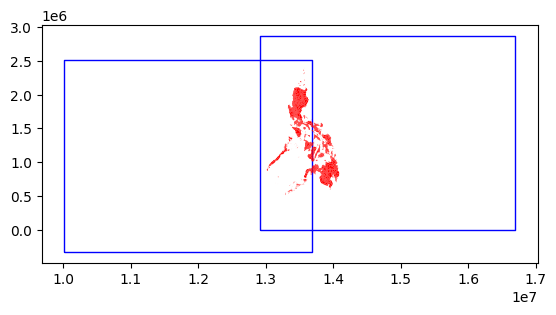

In [ ]:
aoi_ph = gpd.read_file('../data/admin_areas/phl_admbnda_adm3_psa_namria_20200529.shp')
aoi_ph_planar = aoi_ph.to_crs('EPSG:3857')
ax = plt.axes()
ax = sorted_results[:2].plot(ax=ax, facecolor='none', edgecolor='blue')
ax = aoi_ph_planar.plot(ax=ax,color='red')

So the results do look good for the top 2 areas as between them, they cover the entire AOI.

Now, lets download the relevant images

In [ ]:
top2_items = sorted_results[:2].copy()

In [ ]:
%%time
top2_items = download_items(top2_items, dest='../data/ntlights-bigfiles')

CPU times: user 7.02 ms, sys: 1.55 ms, total: 8.57 ms
Wall time: 6.76 ms


Notice how fast the times are 

> _this is because the files were already downloaded into the directory -- the time taken to download new files can take about 10-15 minutes depending on your internet connection_

In [ ]:
top2_items[['image_path']]

,image_path
81,/home/butch2/play/devpost/ntlights-damage-assessment/nbs/../data/ntlights-bigfiles/npp_201805/SVDNB_npp_d20180501_t1...
90,/home/butch2/play/devpost/ntlights-damage-assessment/nbs/../data/ntlights-bigfiles/npp_201805/SVDNB_npp_d20180501_t1...


These now display the path to image files -- which you can then open for analysis using rasterio or any other python package. 